In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json from your Kaggle API account

Saving kaggle.json to kaggle (3).json


{'kaggle (3).json': b'{"username":"najouamardi","key":"9b5851a5c4662f8331704e311655a4a7"}'}

In [ ]:
#connecting to kaggle


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Replace 'username/dataset-name' with your actual path
!kaggle datasets download -d najouamardi/sample_sentiment_100k
!unzip sample_sentiment_100k.zip

403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/metadata/najouamardi/sample_sentiment_100k
unzip:  cannot find or open sample_sentiment_100k.zip, sample_sentiment_100k.zip.zip or sample_sentiment_100k.zip.ZIP.


In [ ]:
df = pd.read_csv('processed_reviews_7milles.csv')
df.head()

,rating,title,text,timestamp,helpful_vote,verified_purchase,label,full_text,sentiment
0,1.0,malware,mcaffee IS malware,1562182632076,0,0,negative,malware mcaffee is malware,negative
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,1424120336000,0,1,positive,lots of fun i love playing tapped out because ...,positive
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,1362399267000,0,1,positive,light up the dark i love this flashlight app i...,positive
3,4.0,Fun game,One of my favorite games,1561061428662,0,1,positive,fun game one of my favorite games,positive
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,1418257196000,0,1,positive,i am not that good at it but my kids are cute ...,positive


In [ ]:
print("shape ",df.shape)
print("checking if data is missing",df.isnull().sum())
print("data types of columns",df.dtypes)

shape  (7000, 9)
checking if data is missing rating               0
title                1
text                 0
timestamp            0
helpful_vote         0
verified_purchase    0
label                0
full_text            0
sentiment            0
dtype: int64
data types of columns rating               float64
title                 object
text                  object
timestamp              int64
helpful_vote           int64
verified_purchase      int64
label                 object
full_text             object
sentiment             object
dtype: object


In [ ]:
#Summary statistics for numeric columns
df.describe()

,rating,timestamp,helpful_vote,verified_purchase
count,7000.000000,7.000000e+03,7000.000000,7000.000000
mean,3.818714,1.501941e+12,4.374429,0.924714
std,1.462048,9.431288e+10,19.697272,0.263871
min,1.000000,9.657194e+11,0.000000,0.000000
25%,3.000000,1.439108e+12,0.000000,1.000000
50%,5.000000,1.514800e+12,0.000000,1.000000
75%,5.000000,1.572353e+12,3.000000,1.000000
max,5.000000,1.678895e+12,797.000000,1.000000


In [ ]:
# Check the value counts of relevant categorical columns (e.g., "rating", "helpfulness")
df['rating'].value_counts()

,count
rating,
5.0,3521
4.0,1163
1.0,966
3.0,808
2.0,542


In [ ]:
rating_counts = df["rating"].value_counts().sort_index()
rating_percentages = (rating_counts / rating_counts.sum()) * 100

# Display nicely
rating_distribution = pd.DataFrame({
    "count": rating_counts,
    "percentage": rating_percentages.round(2)
})

print(rating_distribution)

        count  percentage
rating                   
1.0       966       13.80
2.0       542        7.74
3.0       808       11.54
4.0      1163       16.61
5.0      3521       50.30


<Axes: title={'center': 'Distribution of Ratings'}, xlabel='rating'>

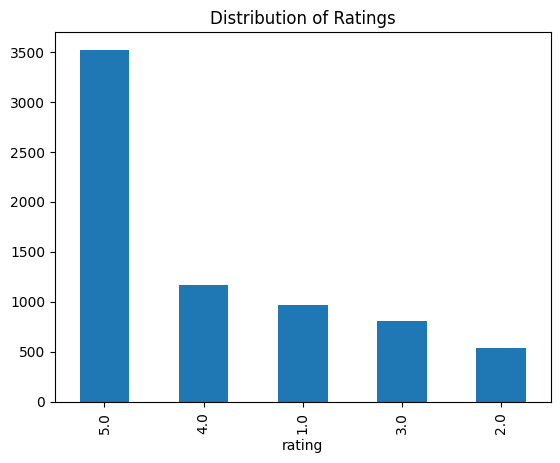

In [ ]:
# If the dataset has a rating column or sentiment labels, explore their distribution
df['rating'].value_counts().plot(kind='bar', title='Distribution of Ratings')

In [ ]:
sentiment_counts = df["sentiment"].value_counts()
sentiment_percentages = (sentiment_counts / len(df)) * 100
sentiment_summary = pd.DataFrame({
    "count": sentiment_counts,
    "percentage": sentiment_percentages.round(2)
})
print(sentiment_summary)

           count  percentage
sentiment                   
positive    4445       63.50
negative    1591       22.73
neutral      964       13.77


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#stemmer = PorterStemmer()

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stop words
    tokens = [word for word in text.split() if word not in stop_words]
    # Stemming
    #stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply to full_text (title+text)
df['clean_full_text'] = df['full_text'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df[:50]

,rating,title,text,timestamp,helpful_vote,verified_purchase,label,full_text,sentiment,clean_full_text
0,1.0,malware,mcaffee IS malware,1562182632076,0,0,negative,malware mcaffee is malware,negative,malware mcaffee malware
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,1424120336000,0,1,positive,lots of fun i love playing tapped out because ...,positive,lots fun love playing tapped fun watch town gr...
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,1362399267000,0,1,positive,light up the dark i love this flashlight app i...,positive,light dark love flashlight app really illumina...
3,4.0,Fun game,One of my favorite games,1561061428662,0,1,positive,fun game one of my favorite games,positive,fun game one favorite games
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,1418257196000,0,1,positive,i am not that good at it but my kids are cute ...,positive,good kids cute game good kids love nik wallenda
5,4.0,good game,"Made me think , variety of the puzzles kept it...",1374994387000,0,1,positive,good game made me think variety of the puzzles...,positive,good game made think variety puzzles kept fun ...
6,5.0,My favorite showVoice my favorite show,See the voice anytime my My favorite show,1520456160247,0,1,positive,my favorite showvoice my favorite show see the...,positive,favorite showvoice favorite show see voice any...
7,5.0,Great Antivirus product,Not sure what else can be said about Norton pr...,1384358113000,0,0,positive,great antivirus product not sure what else can...,positive,great antivirus product sure else said norton ...
8,1.0,Fraught with too many problems,Save your money and purchase a good (i.e. Nort...,1366378695000,0,0,negative,fraught with too many problems save your money...,negative,fraught many problems save money purchase good...
9,4.0,Norton Internet Security,I always use Norton as my PC security applicat...,1365671303000,0,0,positive,norton internet security i always use norton a...,positive,norton internet security always use norton pc ...


In [ ]:
X = df['clean_full_text']
y = df['sentiment']

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Split your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

f1_scorer = make_scorer(f1_score, average='weighted')

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('chi2', SelectKBest(score_func=chi2)),    ###Chi-Squared Test (chi²): A statistical test that can be used to evaluate the importance of each feature for classification.
    ('clf', LinearSVC(class_weight='balanced'))    #('clf', LinearSVC(class_weight='balanced'))
])

# Hyperparameters to tune
param_grid = {
    'tfidf__max_features': [4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'chi2__k': [2000, 3000],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__max_iter': [1000, 3000]
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Grid search
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

#Predictions on test set
y_pred = grid.predict(X_test)

# Print best parameters (based on F1)
print("Best max_features (TF-IDF):", grid.best_params_['tfidf__max_features'])
print("Best ngram_range (TF-IDF):", grid.best_params_['tfidf__ngram_range'])
print("Best k (SelectKBest):", grid.best_params_['chi2__k'])
print("Best C (LinearSVC):", grid.best_params_['clf__C'])
print("Best parameters (F1 score):", grid.best_score_)

# Show both F1 and Accuracy on the test set
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))  #if classes are balanced
print("Test F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted')) #if classes are imbalanced
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))  # Shows precision, recall, F1 per class

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best max_features (TF-IDF): 4000
Best ngram_range (TF-IDF): (1, 1)
Best k (SelectKBest): 2000
Best C (LinearSVC): 0.01
Best parameters (F1 score): nan
Test Accuracy: 0.8064285714285714
Test F1 Score (macro): 0.6986878054689839
Test F1 Score (weighted): 0.7853152305257436

Classification Report:

              precision    recall  f1-score   support

    negative       0.85      0.62      0.72       320
     neutral       0.85      0.35      0.50       207
    positive       0.79      0.98      0.88       873

    accuracy                           0.81      1400
   macro avg       0.83      0.65      0.70      1400
weighted avg       0.81      0.81      0.79      1400

Confusion Matrix:
 [[200   6 114]
 [ 25  73 109]
 [ 10   7 856]]


The model is very good at predicting positives (high true positive count).

It struggles more with negative and neutral classes, often confusing negative with positive and neutral with positive.

The neutral class is the hardest to predict correctly here.

In [3]:
df = pd.read_csv('sample_sentiment_100k.csv')
df.shape

(100000, 11)

In [ ]:
!kaggle datasets download -d najouamardi/sample_sentiment_100k
!unzip sample_sentiment_100k.zip

403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/metadata/najouamardi/sample_sentiment_100k
unzip:  cannot find or open sample_sentiment_100k.zip, sample_sentiment_100k.zip.zip or sample_sentiment_100k.zip.ZIP.


In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# Load model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Use CPU
device = torch.device("cpu")
model.to(device)

# Prediction function
def predict_sentiment(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).tolist()
    return preds

# Mapping star rating to sentiment
def map_sentiment(pred):
    if pred == 0 or pred == 1:  # 1 or 2 stars
        return "negative"
    elif pred == 2:             # 3 stars
        return "neutral"
    else:                       # 4 or 5 stars
        return "positive"

# File paths
input_csv_path = "sample_sentiment_100k.csv"
output_csv_path = "labeled_reviews100.csv"
col_reviews = "full_text"

# Set chunk size
chunk_size = 450
labeled_chunks = []

# Count total rows for progress bar
total_lines = sum(1 for _ in open(input_csv_path)) - 1  # minus header
total_chunks = total_lines // chunk_size + 1

print(f"Total reviews: {total_lines} — Processing in {total_chunks} chunks...\n")

# Loop with progress bar
for chunk in tqdm(pd.read_csv(input_csv_path, chunksize=chunk_size), total=total_chunks, desc="Processing chunks"):
    texts = chunk[col_reviews].astype(str).tolist()
    preds = predict_sentiment(texts)
    chunk['star_rating'] = [p + 1 for p in preds]
    chunk['sentiment_label'] = [map_sentiment(p) for p in preds]
    labeled_chunks.append(chunk)

# Merge and save
result_df = pd.concat(labeled_chunks, ignore_index=True)
result_df.to_csv(output_csv_path, index=False)

print(f"\n✅ Done! Saved {len(result_df)} labeled reviews to `{output_csv_path}`.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Total reviews: 100000 — Processing in 223 chunks...



Processing chunks:   1%|▏         | 3/223 [58:04<70:58:57, 1161.53s/it]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# Load model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Use CPU
device = torch.device("cpu")
model.to(device)

# Prediction function
def predict_sentiment(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).tolist()
    return preds

# Mapping star rating to sentiment
def map_sentiment(pred):
    if pred in [0, 1]:  # 1 or 2 stars
        return "negative"
    elif pred == 2:    # 3 stars
        return "neutral"
    else:              # 4 or 5 stars
        return "positive"

# File paths
input_csv_path = "sample_sentiment_100k.csv"
output_csv_path = "labeled_reviews_15k.csv"
col_reviews = "full_text"

chunk_size = 500
max_rows = 15000  # Process only first 15k rows

labeled_chunks = []

# Count total rows for progress bar, capped by max_rows
with open(input_csv_path, 'r', encoding='utf-8') as f:
    total_lines = sum(1 for _ in f) - 1  # minus header

total_lines = min(total_lines, max_rows)
total_chunks = (total_lines + chunk_size - 1) // chunk_size  # ceiling division

print(f"Processing {total_lines} reviews (max {max_rows}) in {total_chunks} chunks...\n")

processed_rows = 0

for i, chunk in enumerate(pd.read_csv(input_csv_path, chunksize=chunk_size)):
    if processed_rows >= max_rows:
        break

    # If last chunk might exceed max_rows, trim it
    if processed_rows + len(chunk) > max_rows:
        chunk = chunk.iloc[: max_rows - processed_rows]

    texts = chunk[col_reviews].astype(str).tolist()
    preds = predict_sentiment(texts)
    chunk['star_rating'] = [p + 1 for p in preds]
    chunk['sentiment_label'] = [map_sentiment(p) for p in preds]
    labeled_chunks.append(chunk)

    processed_rows += len(chunk)
    print(f"Processed chunk {i+1}/{total_chunks} — total rows processed: {processed_rows}")

result_df = pd.concat(labeled_chunks, ignore_index=True)
result_df.to_csv(output_csv_path, index=False)

print(f"\nDone! Saved {len(result_df)} labeled reviews to `{output_csv_path}`.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Processing 15000 reviews (max 15000) in 30 chunks...

